<div class="alert alert-success">  
    <h1 align="center" style="color:darkcyan;">Please pay attention:</h1>  
</div>

### This notebook is just a fork of the following great notebook:

#### https://www.kaggle.com/code/taroz1461/carrier-smoothing-robust-wls-kalman-smoother

### Thanks to: @taroz1461

<div class="alert alert-success"> 
</div>

# Introduction
**Revised the following points on 6/14 (Version 4):**
- Estimated position and velocity variances by WLS and used for KF
- Improved velocity estimation on XiaomiMi8

-----------------------
This notebook is an example of weighted least squares (WLS)-based GNSS single point positioning using only the provided `device_gnss.csv` and Kalman smoother. The WLS code is based on @junkoda 's [code](https://www.kaggle.com/code/junkoda/deriving-baseline-wls-positions-in-progress) and [code](https://www.kaggle.com/code/junkoda/wls-velocity-estimation-from-doppler-shift). Thank you very match!

The major features of this notebook are as follows
- Speedup of WSL computation by linearization and Jacobi matrix calculation
- Application of robust optimization methods for outliers
- [Carrier smoothing](https://gssc.esa.int/navipedia/index.php/Carrier-smoothing_of_code_pseudoranges) of noisy pseudorange with carrier phase (ADR) observation
- Estimated WLS position and velocity are integrated using the simple Kalman Smoother 

This notebook is a basic pseudorange based WSL with minimal processing of position and velocity integration, so there is a lot of room for improvement!

In [1]:
!pip install pymap3d

import numpy as np
import pandas as pd
import pymap3d as pm
import pymap3d.vincenty as pmv
import matplotlib.pyplot as plt
import glob as gl
import scipy.optimize
from tqdm.auto import tqdm
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.spatial import distance

# Constants
CLIGHT = 299_792_458   # speed of light (m/s)
RE_WGS84 = 6_378_137   # earth semimajor axis (WGS84) (m)
OMGE = 7.2921151467E-5  # earth angular velocity (IS-GPS) (rad/s)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 654.7 kB/s eta 0:00:00 0:00:01


# Satellite Selection

In [2]:
# Satellite selection using carrier frequency error, elevation angle, and C/N0
def satellite_selection(df, column):
    """
    Args:
        df : DataFrame from device_gnss.csv
        column : Column name
    Returns:
        df: DataFrame with eliminated satellite signals
    """
    idx = df[column].notnull()
    idx &= df['CarrierErrorHz'] < 2.0e6  # carrier frequency error (Hz)
    idx &= df['SvElevationDegrees'] > 10.0  # elevation angle (deg)
    idx &= df['Cn0DbHz'] > 15.0  # C/N0 (dB-Hz)
    idx &= df['MultipathIndicator'] == 0 # Multipath flag

    return df[idx]

# Pseudorange/Doppler Residuals and Jacobian

In [3]:
# Compute line-of-sight vector from user to satellite
def los_vector(xusr, xsat):
    """
    Args:
        xusr : user position in ECEF (m)
        xsat : satellite position in ECEF (m)
    Returns:
        u: unit line-of-sight vector in ECEF (m)
        rng: distance between user and satellite (m)
    """
    u = xsat - xusr
    rng = np.linalg.norm(u, axis=1).reshape(-1, 1)
    u /= rng
    
    return u, rng.reshape(-1)


# Compute Jacobian matrix
def jac_pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(pr), 1])])  # J = [-ux -uy -uz 1]

    return W @ J


# Compute pseudorange residuals
def pr_residuals(x, xsat, pr, W):
    """
    Args:
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        pr : pseudorange (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange residuals
    """
    u, rng = los_vector(x[:3], xsat)

    # Approximate correction of the earth rotation (Sagnac effect) often used in GNSS positioning
    rng += OMGE * (xsat[:, 0] * x[1] - xsat[:, 1] * x[0]) / CLIGHT

    # Add GPS L1 clock offset
    residuals = rng - (pr - x[3])

    return residuals @ W


# Compute Jacobian matrix
def jac_prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        W*J : Jacobian matrix
    """
    u, _ = los_vector(x[:3], xsat)
    J = np.hstack([-u, np.ones([len(prr), 1])])

    return W @ J


# Compute pseudorange rate residuals
def prr_residuals(v, vsat, prr, x, xsat, W):
    """
    Args:
        v : current velocity in ECEF (m/s)
        vsat : satellite velocity in ECEF (m/s)
        prr : pseudorange rate (m/s)
        x : current position in ECEF (m)
        xsat : satellite position in ECEF (m)
        W : weight matrix
    Returns:
        residuals*W : pseudorange rate residuals
    """
    u, rng = los_vector(x[:3], xsat)
    rate = np.sum((vsat-v[:3])*u, axis=1) \
          + OMGE / CLIGHT * (vsat[:, 1] * x[0] + xsat[:, 1] * v[0]
                           - vsat[:, 0] * x[1] - xsat[:, 0] * v[1])

    residuals = rate - (prr - v[3])

    return residuals @ W

# Carrier Smoothing
Smoothing noisy pseudoranges with accurate (but absolute distance bias exists) carrier phase. Note that this is a post-processing method. The average absolute distance is added to continuously observed carrier phase.

In [4]:
# Carrier smoothing of pseudarange
def carrier_smoothing(gnss_df):
    """
    Args:
        df : DataFrame from device_gnss.csv
    Returns:
        df: DataFrame with carrier-smoothing pseudorange 'pr_smooth'
    """
    carr_th = 1.5 # carrier phase jump threshold [m] ** 2.0 -> 1.5 **
    pr_th =  22.0 # pseudorange jump threshold [m]

    prsmooth = np.full_like(gnss_df['RawPseudorangeMeters'], np.nan)
    # Loop for each signal
    for (i, (svid_sigtype, df)) in enumerate((gnss_df.groupby(['Svid', 'SignalType']))):
        df = df.replace(
            {'AccumulatedDeltaRangeMeters': {0: np.nan}})  # 0 to NaN

        # Compare time difference between pseudorange/carrier with Doppler
        drng1 = df['AccumulatedDeltaRangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']
        drng2 = df['RawPseudorangeMeters'].diff() - df['PseudorangeRateMetersPerSecond']

        # Check cycle-slip
        slip1 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**1) != 0  # reset flag
        slip2 = (df['AccumulatedDeltaRangeState'].to_numpy() & 2**2) != 0  # cycle-slip flag
        slip3 = np.fabs(drng1.to_numpy()) > carr_th # Carrier phase jump
        slip4 = np.fabs(drng2.to_numpy()) > pr_th # Pseudorange jump

        idx_slip = slip1 | slip2 | slip3 | slip4
        idx_slip[0] = True

        # groups with continuous carrier phase tracking
        df['group_slip'] = np.cumsum(idx_slip)

        # Psudorange - carrier phase
        df['dpc'] = df['RawPseudorangeMeters'] - df['AccumulatedDeltaRangeMeters']

        # Absolute distance bias of carrier phase
        meandpc = df.groupby('group_slip')['dpc'].mean()
        df = df.merge(meandpc, on='group_slip', suffixes=('', '_Mean'))

        # Index of original gnss_df
        idx = (gnss_df['Svid'] == svid_sigtype[0]) & (
            gnss_df['SignalType'] == svid_sigtype[1])

        # Carrier phase + bias
        prsmooth[idx] = df['AccumulatedDeltaRangeMeters'] + df['dpc_Mean']

    # If carrier smoothing is not possible, use original pseudorange
    idx_nan = np.isnan(prsmooth)
    prsmooth[idx_nan] = gnss_df['RawPseudorangeMeters'][idx_nan]
    gnss_df['pr_smooth'] = prsmooth

    return gnss_df

# Score Computation

In [5]:
# Compute distance by Vincenty's formulae
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

# Robust WLS
I used `soft_l1` loss function. It is robust, but its computation speed is considerably slower than that of ordinary least squares...

In [6]:
# GNSS single point positioning using pseudorange
def point_positioning(gnss_df):
    # Add nominal frequency to each signal
    # Note: GLONASS is an FDMA signal, so each satellite has a different frequency
    CarrierFrequencyHzRef = gnss_df.groupby(['Svid', 'SignalType'])[
        'CarrierFrequencyHz'].median()
    gnss_df = gnss_df.merge(CarrierFrequencyHzRef, how='left', on=[
                            'Svid', 'SignalType'], suffixes=('', 'Ref'))
    gnss_df['CarrierErrorHz'] = np.abs(
        (gnss_df['CarrierFrequencyHz'] - gnss_df['CarrierFrequencyHzRef']))

    # Carrier smoothing
    gnss_df = carrier_smoothing(gnss_df)

    # GNSS single point positioning
    utcTimeMillis = gnss_df['utcTimeMillis'].unique()
    nepoch = len(utcTimeMillis)
    x0 = np.zeros(4)  # [x,y,z,tGPSL1]
    v0 = np.zeros(4)  # [vx,vy,vz,dtGPSL1]
    x_wls = np.full([nepoch, 3], np.nan)  # For saving position
    v_wls = np.full([nepoch, 3], np.nan)  # For saving velocity
    cov_x = np.full([nepoch, 3, 3], np.nan) # For saving position covariance
    cov_v = np.full([nepoch, 3, 3], np.nan) # For saving velocity covariance

    # Loop for epochs
    for i, (t_utc, df) in enumerate(tqdm(gnss_df.groupby('utcTimeMillis'), total=nepoch)):
        # Valid satellite selection
        df_pr = satellite_selection(df, 'pr_smooth')
        df_prr = satellite_selection(df, 'PseudorangeRateMetersPerSecond')

        # Corrected pseudorange/pseudorange rate
        pr = (df_pr['pr_smooth'] + df_pr['SvClockBiasMeters'] - df_pr['IsrbMeters'] -
              df_pr['IonosphericDelayMeters'] - df_pr['TroposphericDelayMeters']).to_numpy()
        prr = (df_prr['PseudorangeRateMetersPerSecond'] +
               df_prr['SvClockDriftMetersPerSecond']).to_numpy()

        # Satellite position/velocity
        xsat_pr = df_pr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                         'SvPositionZEcefMeters']].to_numpy()
        xsat_prr = df_prr[['SvPositionXEcefMeters', 'SvPositionYEcefMeters',
                           'SvPositionZEcefMeters']].to_numpy()
        vsat = df_prr[['SvVelocityXEcefMetersPerSecond', 'SvVelocityYEcefMetersPerSecond',
                       'SvVelocityZEcefMetersPerSecond']].to_numpy()

        # Weight matrix for peseudorange/pseudorange rate
        Wx = np.diag(1 / df_pr['RawPseudorangeUncertaintyMeters'].to_numpy())
        Wv = np.diag(1 / df_prr['PseudorangeRateUncertaintyMetersPerSecond'].to_numpy())

        # Robust WLS requires accurate initial values for convergence,
        # so perform normal WLS for the first time
        if len(df_pr) >= 4:
            # Normal WLS
            if np.all(x0 == 0):
                opt = scipy.optimize.least_squares(
                    pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx))
                x0 = opt.x 
            # Robust WLS for position estimation
            opt = scipy.optimize.least_squares(
                 pr_residuals, x0, jac_pr_residuals, args=(xsat_pr, pr, Wx), loss='soft_l1')
            if opt.status < 1 or opt.status == 2:
                print(f'i = {i} position lsq status = {opt.status}')
            else:
                # Covariance estimation
                cov = np.linalg.inv(opt.jac.T @ Wx @ opt.jac)
                cov_x[i, :, :] = cov[:3, :3]
                x_wls[i, :] = opt.x[:3]
                x0 = opt.x
                 
        # Velocity estimation
        if len(df_prr) >= 4:
            if np.all(v0 == 0): # Normal WLS
                opt = scipy.optimize.least_squares(
                    prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv))
                v0 = opt.x
            # Robust WLS for velocity estimation
            opt = scipy.optimize.least_squares(
                prr_residuals, v0, jac_prr_residuals, args=(vsat, prr, x0, xsat_prr, Wv), loss='soft_l1')
            if opt.status < 1:
                print(f'i = {i} velocity lsq status = {opt.status}')
            else:
                # Covariance estimation
                cov = np.linalg.inv(opt.jac.T @ Wv @ opt.jac)
                cov_v[i, :, :] = cov[:3, :3]
                v_wls[i, :] = opt.x[:3]
                v0 = opt.x

    return utcTimeMillis, x_wls, v_wls, cov_x, cov_v

# Outlier Detection and Interpolation

In [7]:
# Simple outlier detection and interpolation
def exclude_interpolate_outlier(x_wls, v_wls, cov_x, cov_v):
    # Up velocity / height threshold
    v_up_th = 3.0  # m/s
    height_th = 150.0 # m
    v_out_sigma = 3.0 # m/s
    x_out_sigma = 30.0 # m
    
    # Coordinate conversion
    x_llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
    x_llh_mean = np.nanmean(x_llh, axis=0)
    v_enu = np.array(pm.ecef2enuv(
        v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], x_llh_mean[0], x_llh_mean[1])).T

    # Up velocity jump detection
    # Cars don't jump suddenly!
    idx_v_out = np.abs(v_enu[:, 2]) > v_up_th
    idx_v_out |= np.isnan(v_enu[:, 2])
    v_wls[idx_v_out, :] = np.nan
    cov_v[idx_v_out] = v_out_sigma**2 * np.eye(3)
    print(f'Number of velocity outliers {np.count_nonzero(idx_v_out)}')

    # Height check
    hmedian = np.nanmedian(x_llh[:, 2])
    idx_x_out = np.abs(x_llh[:, 2] - hmedian) > height_th
    idx_x_out |= np.isnan(x_llh[:, 2])
    x_wls[idx_x_out, :] = np.nan
    cov_x[idx_x_out] = x_out_sigma**2 * np.eye(3)
    print(f'Number of position outliers {np.count_nonzero(idx_x_out)}')

    # Interpolate NaNs at beginning and end of array
    x_df = pd.DataFrame({'x': x_wls[:, 0], 'y': x_wls[:, 1], 'z': x_wls[:, 2]})
    x_df = x_df.interpolate(limit_area='outside', limit_direction='both')

    # Interpolate all NaN data
    v_df = pd.DataFrame({'x': v_wls[:, 0], 'y': v_wls[:, 1], 'z': v_wls[:, 2]})
    v_df = v_df.interpolate(limit_area='outside', limit_direction='both')
    v_df = v_df.interpolate('spline', order=3)

    return x_df.to_numpy(), v_df.to_numpy(), cov_x, cov_v

# Kalman Smoother
Application of Kalman smoother; integration of velocity and position obtained by WLS.
The covariance matrix is a fixed value.

In [8]:
# Kalman filter
def Kalman_filter(zs, us, cov_zs, cov_us, phone):
    # Parameters
    sigma_mahalanobis = 30.0  # Mahalanobis distance for rejecting innovation

    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    H = np.eye(3)  # Measurement function

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = 5.0**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        Q = cov_us[i] # Estimated WLS velocity covariance
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.inv(P))

        # Update step
        if d < sigma_mahalanobis:
            R = cov_zs[i] # Estimated WLS position covariance
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If observation update is not available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls, cov_x, cov_v, phone):
    n, dim_x = x_wls.shape

    # For some unknown reason, the speed estimation is wrong only for XiaomiMi8
    # so the variance is increased
    if phone == 'XiaomiMi8':
        v_wls = np.vstack([(v_wls[:-1, :] + v_wls[1:, :])/2, np.zeros([1, 3])])
        cov_v = 1000.0**2 * cov_v
         
    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v, cov_x, cov_v, phone)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    cov_xf = np.flip(cov_x, axis=0)
    cov_vf = np.flip(cov_v, axis=0)
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v, cov_xf, cov_vf, phone)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

# Train data

  0%|          | 0/1917 [00:00<?, ?it/s]

Number of velocity outliers 1
Number of position outliers 0
Score Baseline   7.9576 [m]
Score Robust WLS 7.5062 [m]
Score KF         2.2928 [m]


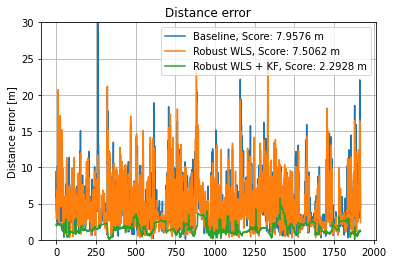

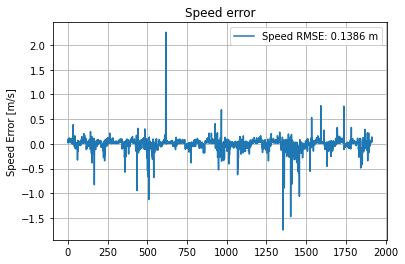

In [9]:
# Target course/phone
path = '/kaggle/input/smartphone-decimeter-2022/train/2021-03-16-US-MTV-1/GooglePixel4XL'

drive, phone = path.split('/')[-2:]

# Read data
gnss_df = pd.read_csv(f'{path}/device_gnss.csv')  # GNSS data
gt_df = pd.read_csv(f'{path}/ground_truth.csv')  # ground truth

# Point positioning
utc, x_wls, v_wls, cov_x, cov_v = point_positioning(gnss_df)

# Exclude velocity outliers
x_wls, v_wls, cov_x, cov_v = exclude_interpolate_outlier(x_wls, v_wls, cov_x, cov_v)

# Kalman smoothing
x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, cov_x, cov_v, phone)

# Convert to latitude and longitude
llh_wls = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

# Baseline
x_bl = gnss_df.groupby('TimeNanos')[
    ['WlsPositionXEcefMeters', 'WlsPositionYEcefMeters', 'WlsPositionZEcefMeters']].mean().to_numpy()
llh_bl = np.array(pm.ecef2geodetic(x_bl[:, 0], x_bl[:, 1], x_bl[:, 2])).T

# Ground truth
llh_gt = gt_df[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

# Distance from ground truth
vd_bl = vincenty_distance(llh_bl, llh_gt)
vd_wls = vincenty_distance(llh_wls, llh_gt)
vd_kf = vincenty_distance(llh_kf, llh_gt)

# Score
score_bl = calc_score(llh_bl, llh_gt)
score_wls = calc_score(llh_wls, llh_gt)
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])

print(f'Score Baseline   {score_bl:.4f} [m]')
print(f'Score Robust WLS {score_wls:.4f} [m]')
print(f'Score KF         {score_kf:.4f} [m]')

# Plot distance error
plt.figure()
plt.title('Distance error')
plt.ylabel('Distance error [m]')
plt.plot(vd_bl, label=f'Baseline, Score: {score_bl:.4f} m')
plt.plot(vd_wls, label=f'Robust WLS, Score: {score_wls:.4f} m')
plt.plot(vd_kf, label=f'Robust WLS + KF, Score: {score_kf:.4f} m')
plt.legend()
plt.grid()
plt.ylim([0, 30])

# Compute velocity error
speed_wls = np.linalg.norm(v_wls[:, :3], axis=1)
speed_gt = gt_df['SpeedMps'].to_numpy()
speed_rmse = np.sqrt(np.sum((speed_wls-speed_gt)**2)/len(speed_gt))

# Plot velocity error
plt.figure()
plt.title('Speed error')
plt.ylabel('Speed Error [m/s]')
plt.plot(speed_wls - speed_gt, label=f'Speed RMSE: {speed_rmse:.4f} m')
plt.legend()
plt.grid()

# Test data and Submission
This part is based on @saitodevel01 's [code](https://www.kaggle.com/code/saitodevel01/gsdc2-baseline-submission). Thank you!

In [ ]:
path = '/kaggle/input/smartphone-decimeter-2022'
sample_df = pd.read_csv(f'{path}/sample_submission.csv')
test_dfs = []

# Loop for each trip
for i, dirname in enumerate(tqdm(sorted(gl.glob(f'{path}/test/*/*/')))):
    drive, phone = dirname.split('/')[-3:-1]
    tripID = f'{drive}/{phone}'
    print(tripID)

    # Read data
    gnss_df = pd.read_csv(f'{dirname}/device_gnss.csv')

    # Point positioning
    utc, x_wls, v_wls, cov_x, cov_v = point_positioning(gnss_df)

    # Exclude velocity outliers
    x_wls, v_wls, cov_x, cov_v = exclude_interpolate_outlier(x_wls, v_wls, cov_x, cov_v)

    # Kalman smoothing
    x_kf, _, _ = Kalman_smoothing(x_wls, v_wls, cov_x, cov_v, phone)
    assert np.all(~np.isnan(x_kf))

    # Convert to latitude and longitude
    llh_kf = np.array(pm.ecef2geodetic(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2])).T

    # Interpolation for submission
    UnixTimeMillis = sample_df[sample_df['tripId'] == tripID]['UnixTimeMillis'].to_numpy()
    lat = InterpolatedUnivariateSpline(utc, llh_kf[:,0], ext=3)(UnixTimeMillis)
    lng = InterpolatedUnivariateSpline(utc, llh_kf[:,1], ext=3)(UnixTimeMillis)
    trip_df = pd.DataFrame({
        'tripId' : tripID,
        'UnixTimeMillis': UnixTimeMillis,
        'LatitudeDegrees': lat,
        'LongitudeDegrees': lng
        })

    test_dfs.append(trip_df)

# Write submission.csv
test_df = pd.concat(test_dfs)
test_df.to_csv('submission.csv', index=False)

  0%|          | 0/36 [00:00<?, ?it/s]

2021-04-28-US-MTV-2/SamsungGalaxyS20Ultra


  0%|          | 0/1724 [00:00<?, ?it/s]

Number of velocity outliers 1
Number of position outliers 0
2021-06-22-US-MTV-1/XiaomiMi8


  0%|          | 0/1398 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2021-08-12-US-MTV-1/GooglePixel4


  0%|          | 0/1265 [00:00<?, ?it/s]

Number of velocity outliers 5
Number of position outliers 5
2021-08-17-US-MTV-1/GooglePixel5


  0%|          | 0/1673 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2021-08-24-US-SVL-2/GooglePixel5


  0%|          | 0/3314 [00:00<?, ?it/s]

Number of velocity outliers 1
Number of position outliers 0
2021-09-07-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/1802 [00:00<?, ?it/s]

Number of velocity outliers 1
Number of position outliers 0
2021-09-14-US-MTV-1/GooglePixel5


  0%|          | 0/1270 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2021-09-20-US-MTV-1/XiaomiMi8


  0%|          | 0/1795 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2021-09-20-US-MTV-2/GooglePixel4


  0%|          | 0/1742 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2021-09-28-US-MTV-1/GooglePixel5


  0%|          | 0/2485 [00:00<?, ?it/s]

Number of velocity outliers 4
Number of position outliers 0
2021-11-05-US-MTV-1/XiaomiMi8


  0%|          | 0/1442 [00:00<?, ?it/s]

Number of velocity outliers 2
Number of position outliers 0
2021-11-30-US-MTV-1/GooglePixel5


  0%|          | 0/1521 [00:00<?, ?it/s]

Number of velocity outliers 6
Number of position outliers 1
2022-01-04-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/922 [00:00<?, ?it/s]

Number of velocity outliers 2
Number of position outliers 0
2022-01-11-US-MTV-1/GooglePixel6Pro


  0%|          | 0/942 [00:00<?, ?it/s]

Number of velocity outliers 5
Number of position outliers 2
2022-01-18-US-SJC-2/GooglePixel5


  0%|          | 0/942 [00:00<?, ?it/s]

Number of velocity outliers 2
Number of position outliers 0
2022-01-26-US-MTV-1/XiaomiMi8


  0%|          | 0/1698 [00:00<?, ?it/s]

i = 47 position lsq status = 2
i = 49 position lsq status = 2
Number of velocity outliers 2
Number of position outliers 2
2022-02-01-US-SJC-1/XiaomiMi8


  0%|          | 0/910 [00:00<?, ?it/s]

Number of velocity outliers 1
Number of position outliers 0
2022-02-08-US-SJC-1/XiaomiMi8


  0%|          | 0/1665 [00:00<?, ?it/s]

Number of velocity outliers 2
Number of position outliers 1
2022-02-15-US-SJC-1/GooglePixel5


  0%|          | 0/1392 [00:00<?, ?it/s]

Number of velocity outliers 10
Number of position outliers 2
2022-02-23-US-LAX-1/GooglePixel5


  0%|          | 0/2845 [00:00<?, ?it/s]

Number of velocity outliers 9
Number of position outliers 5
2022-02-23-US-LAX-3/XiaomiMi8


  0%|          | 0/2880 [00:00<?, ?it/s]

Number of velocity outliers 89
Number of position outliers 83
2022-02-23-US-LAX-5/XiaomiMi8


  0%|          | 0/2420 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2022-02-24-US-LAX-1/SamsungGalaxyS20Ultra


  0%|          | 0/3581 [00:00<?, ?it/s]

i = 168 position lsq status = 2
i = 172 position lsq status = 2
i = 173 position lsq status = 2
i = 175 position lsq status = 2
i = 178 position lsq status = 2
i = 179 position lsq status = 2
i = 185 position lsq status = 2
i = 186 position lsq status = 2
i = 194 position lsq status = 2
i = 195 position lsq status = 2
i = 198 position lsq status = 2
Number of velocity outliers 7
Number of position outliers 31
2022-02-24-US-LAX-3/XiaomiMi8


  0%|          | 0/2464 [00:00<?, ?it/s]

i = 1135 position lsq status = 2
Number of velocity outliers 6
Number of position outliers 1
2022-02-24-US-LAX-5/SamsungGalaxyS20Ultra


  0%|          | 0/4514 [00:00<?, ?it/s]

Number of velocity outliers 5
Number of position outliers 0
2022-03-14-US-MTV-1/GooglePixel5


  0%|          | 0/1635 [00:00<?, ?it/s]

Number of velocity outliers 2
Number of position outliers 2
2022-03-17-US-SJC-1/GooglePixel5


  0%|          | 0/1172 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2022-03-22-US-MTV-1/SamsungGalaxyS20Ultra


  0%|          | 0/2109 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2022-03-31-US-LAX-1/GooglePixel5


  0%|          | 0/1301 [00:00<?, ?it/s]

Number of velocity outliers 27
Number of position outliers 2
2022-03-31-US-LAX-3/SamsungGalaxyS20Ultra


  0%|          | 0/1820 [00:00<?, ?it/s]

Number of velocity outliers 0
Number of position outliers 0
2022-04-01-US-LAX-1/SamsungGalaxyS20Ultra


  0%|          | 0/1670 [00:00<?, ?it/s]

Number of velocity outliers 9
Number of position outliers 0
2022-04-01-US-LAX-3/XiaomiMi8


  0%|          | 0/1462 [00:00<?, ?it/s]

Number of velocity outliers 12
Number of position outliers 4
2022-04-22-US-OAK-1/GooglePixel5


  0%|          | 0/1432 [00:00<?, ?it/s]